# Fraud detection at self-checkouts in retail


**Scenario**

* The number of self-checkout stations is on the rise. This includes stationary self-checkouts, where customers take their shopping cart to a scan station and pay for their products. Secondly, there are semi-stationary self-checkouts, where customers scan their products directly and only pay at a counter. The customers either use their own smartphone for scanning or the store provides mobile scanners.This automated process helps avoid long lines and speeds up the paying process for individual customers. But how can retailers prevent the trust they have placed in customers from being abused? How can they decide which purchases to check in an effort to expose fraudsters without annoying innocent customers?
* An established food retailer has introduced a self-scanning system that allows customers to scan their items using a handheld mobile scanner while shopping.This type of payment leaves retailers open to the risk that a certain number of customers will take advantage of this freedom to commit fraud by not scanning all of the items in their cart. Empirical research conducted by suppliers has shown that discrepancies are found in approximately 5 % of all self-scan transactions. The research does not differentiate between actual fraudulent intent of the customer, inadvertent errors or technical problems with scanners. To minimize losses, the food retailer hopes to identify cases of fraud using targeted follow- up checks. The challenge here is to keep the number of checks as low as possible to avoid unnecessary added expense as well as to avoid putting off innocent customers due to false accusations. At the same time, however, the goal is to identify as many false scans as possible.

**Variable Description**:

| Column Name | Description | Value range |
|-------------|----------   |----------   |
| Trust Level |A customer’s individual trust level. 6: Highest trustworthiness   | {1,2,3,4,5,6} |
|Total Scan Time In Seconds  | Total time in seconds between the first and last product scanned   | Positive whole number   |
|Grand Total| Grand total of products scanned| Positive decimal number with maximum two decimal places|
|Line Item Voids|Number of voided scans|Positive whole number|
|Scans Without Registration|Number of attempts to activate the scanner without actually scanning anything|Positive whole number or 0|
|Quantity Modification|Number of modified quantities for one of the scanned products|Positive whole number or 0|
|Scanned Line Items Per Second|Average number of scanned products per second|Positive decimal number|
|Value Per Second| Average total value of scanned products per second|Positive decimal number|
|Line Item Voids Per Position| Average number of item voids per total number of all scanned and not cancelled products| Positive decimal number|
|Fraud|Classification as fraud (1) or not fraud (0)|{0,1}|


**Cost Sensitive Matrix**:

|               | actual 1 (fraud) | actual 0 (no fraud) |
|:------------:|:---------------:|:---------------:|
| **predicted 1 (fraud)** | 5 | -25 |
| **predicted 0 (no fraud)** | -5 | 0 |


The food retailer receives a profit of € 5 for every correctly identified fraud attempt. However, for every fraud case that goes unexposed he loses € 5.
A costumer falsely accused of fraud, might not return to this store, which is denoted by a € 25 loss for the retailer.
An honest customer identified correctly means neither profit nor loss for the retailer.
So, `the goal is to get the max profit (reduce mis classification errors, especially false positive).`

# 1. Load data and overview

In [2]:
#load important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings.filterwarnings('ignore')

In [3]:
#read train data
train = pd.read_csv('train.csv', sep='|')

In [4]:
train.info()

#there is no null values
#data types are good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trustLevel                 1879 non-null   int64  
 1   totalScanTimeInSeconds     1879 non-null   int64  
 2   grandTotal                 1879 non-null   float64
 3   lineItemVoids              1879 non-null   int64  
 4   scansWithoutRegistration   1879 non-null   int64  
 5   quantityModifications      1879 non-null   int64  
 6   scannedLineItemsPerSecond  1879 non-null   float64
 7   valuePerSecond             1879 non-null   float64
 8   lineItemVoidsPerPosition   1879 non-null   float64
 9   fraud                      1879 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 146.9 KB


**Validation set**

# 2. Data Visualization (EDA)

get a sense of the training dataset that is used to predict 

## 2.1 Fraud

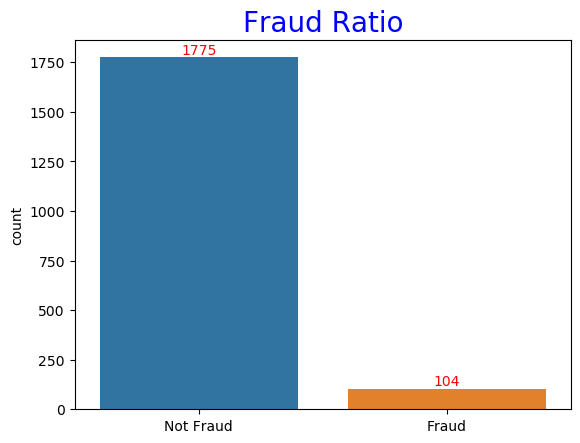

In [5]:
ax = sns.countplot(data=train, x='fraud')
plt.title('Fraud Ratio',size=20,color='blue')
ax.set_xticklabels(['Not Fraud', 'Fraud'])
plt.xlabel(None)

# Iterate through the bars and add the count label to each one
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=10, ha='center', va='bottom',color='red')

**Insights**:

The dataset is `highly imbalanced`, with a large majority of non-fraudulent examples and a small number of fraudulent ones. This could potentially impact the performance of a model built on this data, as it may not have sufficient examples of fraudulent behavior to accurately learn and classify it. To address this issue, we will need to consider techniques for mitigating the effects of imbalanced data during model building

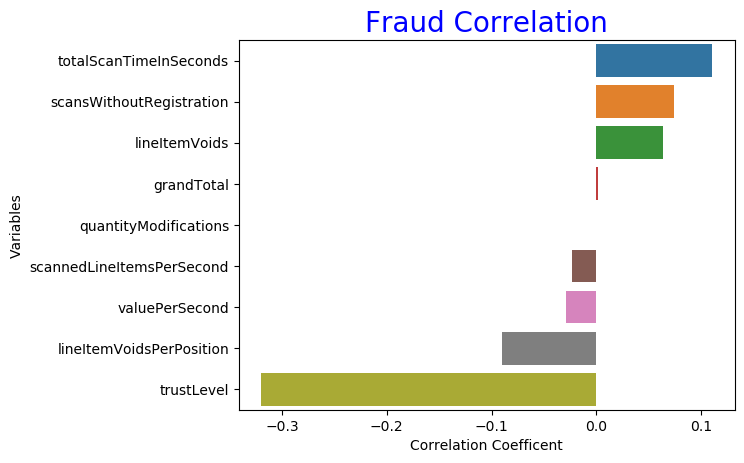

In [6]:
fraud_cor = train.corr()['fraud'].sort_values(ascending=False).to_frame().reset_index()[1:]
fraud_cor.columns = ['Variables','Correlation Coefficent']
sns.barplot(data=fraud_cor,y='Variables',x='Correlation Coefficent')
plt.title('Fraud Correlation',size=20,color='blue');

**Insights**:
* `The total number of items appears to be strongly correlated with fraud, as shown in the graph`. This suggests that the more items a customer purchases, the more likely they are to make mistakes or engage in fraudulent activity. This makes sense, as a larger number of items may increase the chances of errors being made, and individuals intending to commit fraud may try to purchase a large number of items in an attempt to go unnoticed
* `There is a strong negative correlation between trust level and fraud.` This means that customers with high trust levels are less likely to be involved in fraudulent activity.

## 2.2 Customer Trust Level

A customer’s individual trust level.\
6: Highest trustworthiness \
1: Lowest trustworthiness

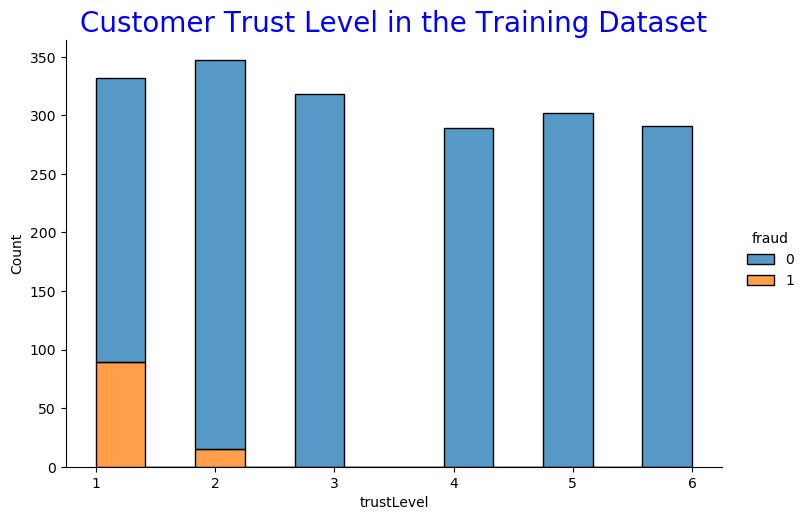

In [7]:
sns.displot(x="trustLevel",data=train,aspect=1.5,hue='fraud',multiple="stack")
plt.title('Customer Trust Level in the Training Dataset',size=20,color='blue');

**Insights**:
* This dataset has an equal number of customers with different trust levels. 
* However, there is a higher concentration of fraudulent examples among customers with low trust levels, which makes sense given that theoretically these individuals may be more likely to engage in fraudulent behavior.

## 2.3 Number of Items

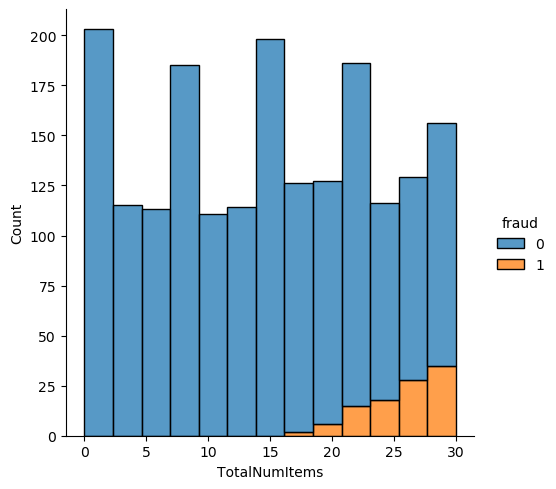

In [8]:
item_plt = train.copy()
item_plt['TotalNumItems'] = item_plt['totalScanTimeInSeconds'] * train['scannedLineItemsPerSecond']
item_plt['TotalNumItems'] = item_plt['TotalNumItems'].astype('int64')

sns.displot(data=item_plt, x='TotalNumItems',hue='fraud',multiple='stack');

**Insights**:
* Yes. It is similar to the fraud correlation chart. Both suggest that the more products a customer purchases, the more likely they are to commit fraud, regardless of whether the fraud is intentional or not.

## 2.4 Correlation Matrix

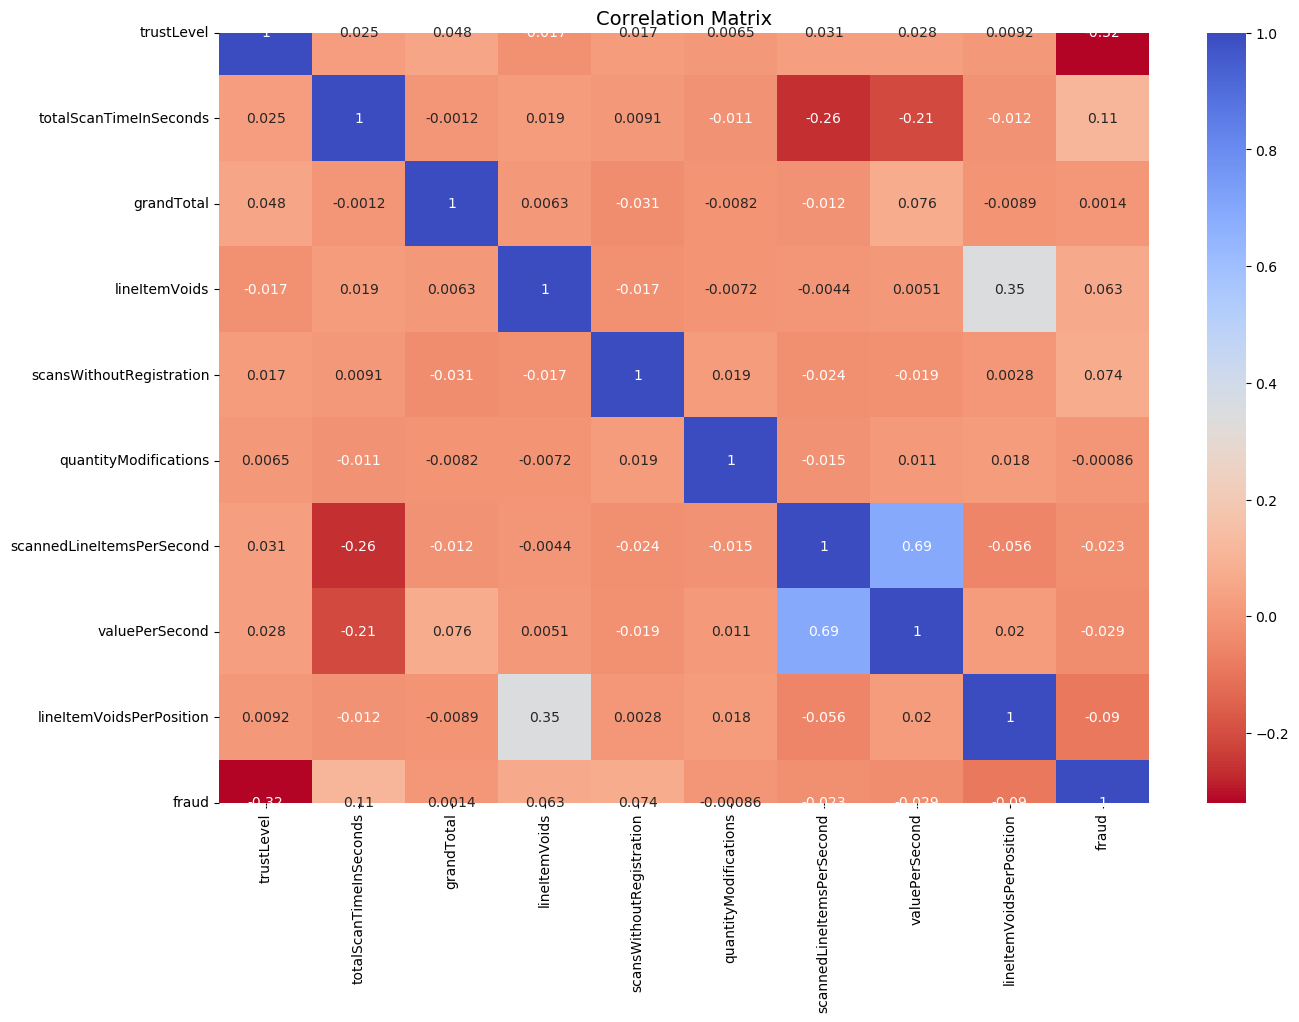

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True,cmap='coolwarm_r')
plt.title("Correlation Matrix", fontsize=14);

**Insights**:
* We don't see any strongly correlated variables in this graph and it suggests that there is not a strong linear relationship between any of the variables. This means that a linear regression model is unlikely to be able to capture the relationships between the variables very well.

## 2.5 Distribution Overview

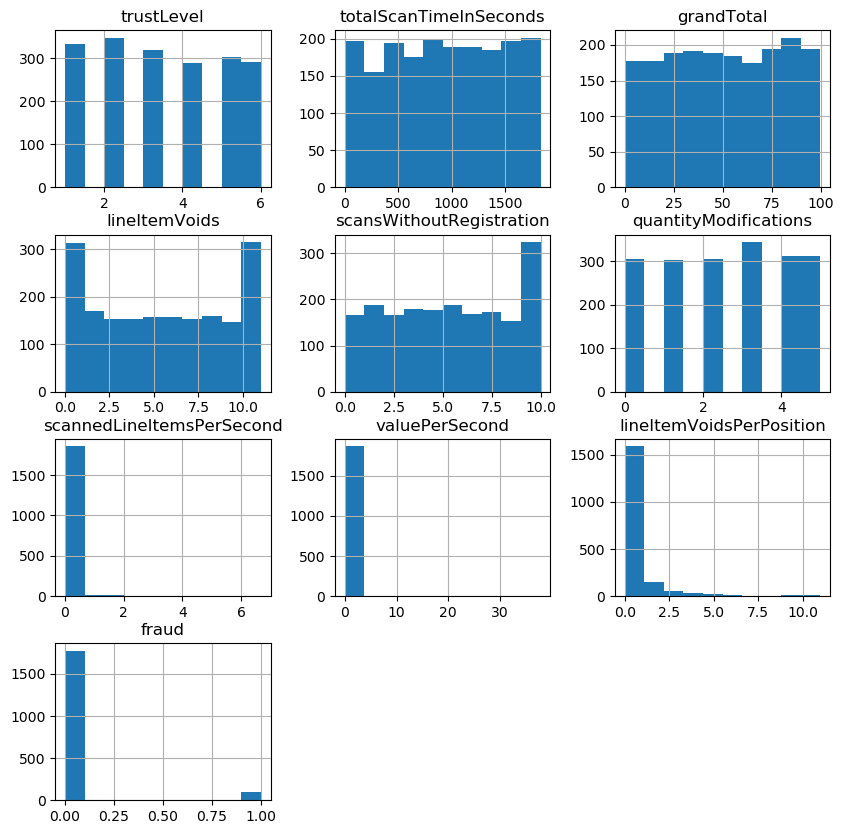

In [10]:
train.hist(figsize=(10, 10));

**Insights**:
* It appears that the three variables, scannedlineitemspersecond, valuepersecond, and lineitemvoidsperposition, are all right-skewed, meaning that they have a longer tail on the right side of the distribution. One potential issue to note is that lineitemvoidsperposition has values that are larger than 7.5, which could potentially be a red flag for fraudulent activity. It is important to carefully investigate this issue and consider other possible explanations before making any conclusions or taking any actions based on the data.

## 2.6 Scatter/Pair Plot

<Figure size 1500x1000 with 0 Axes>

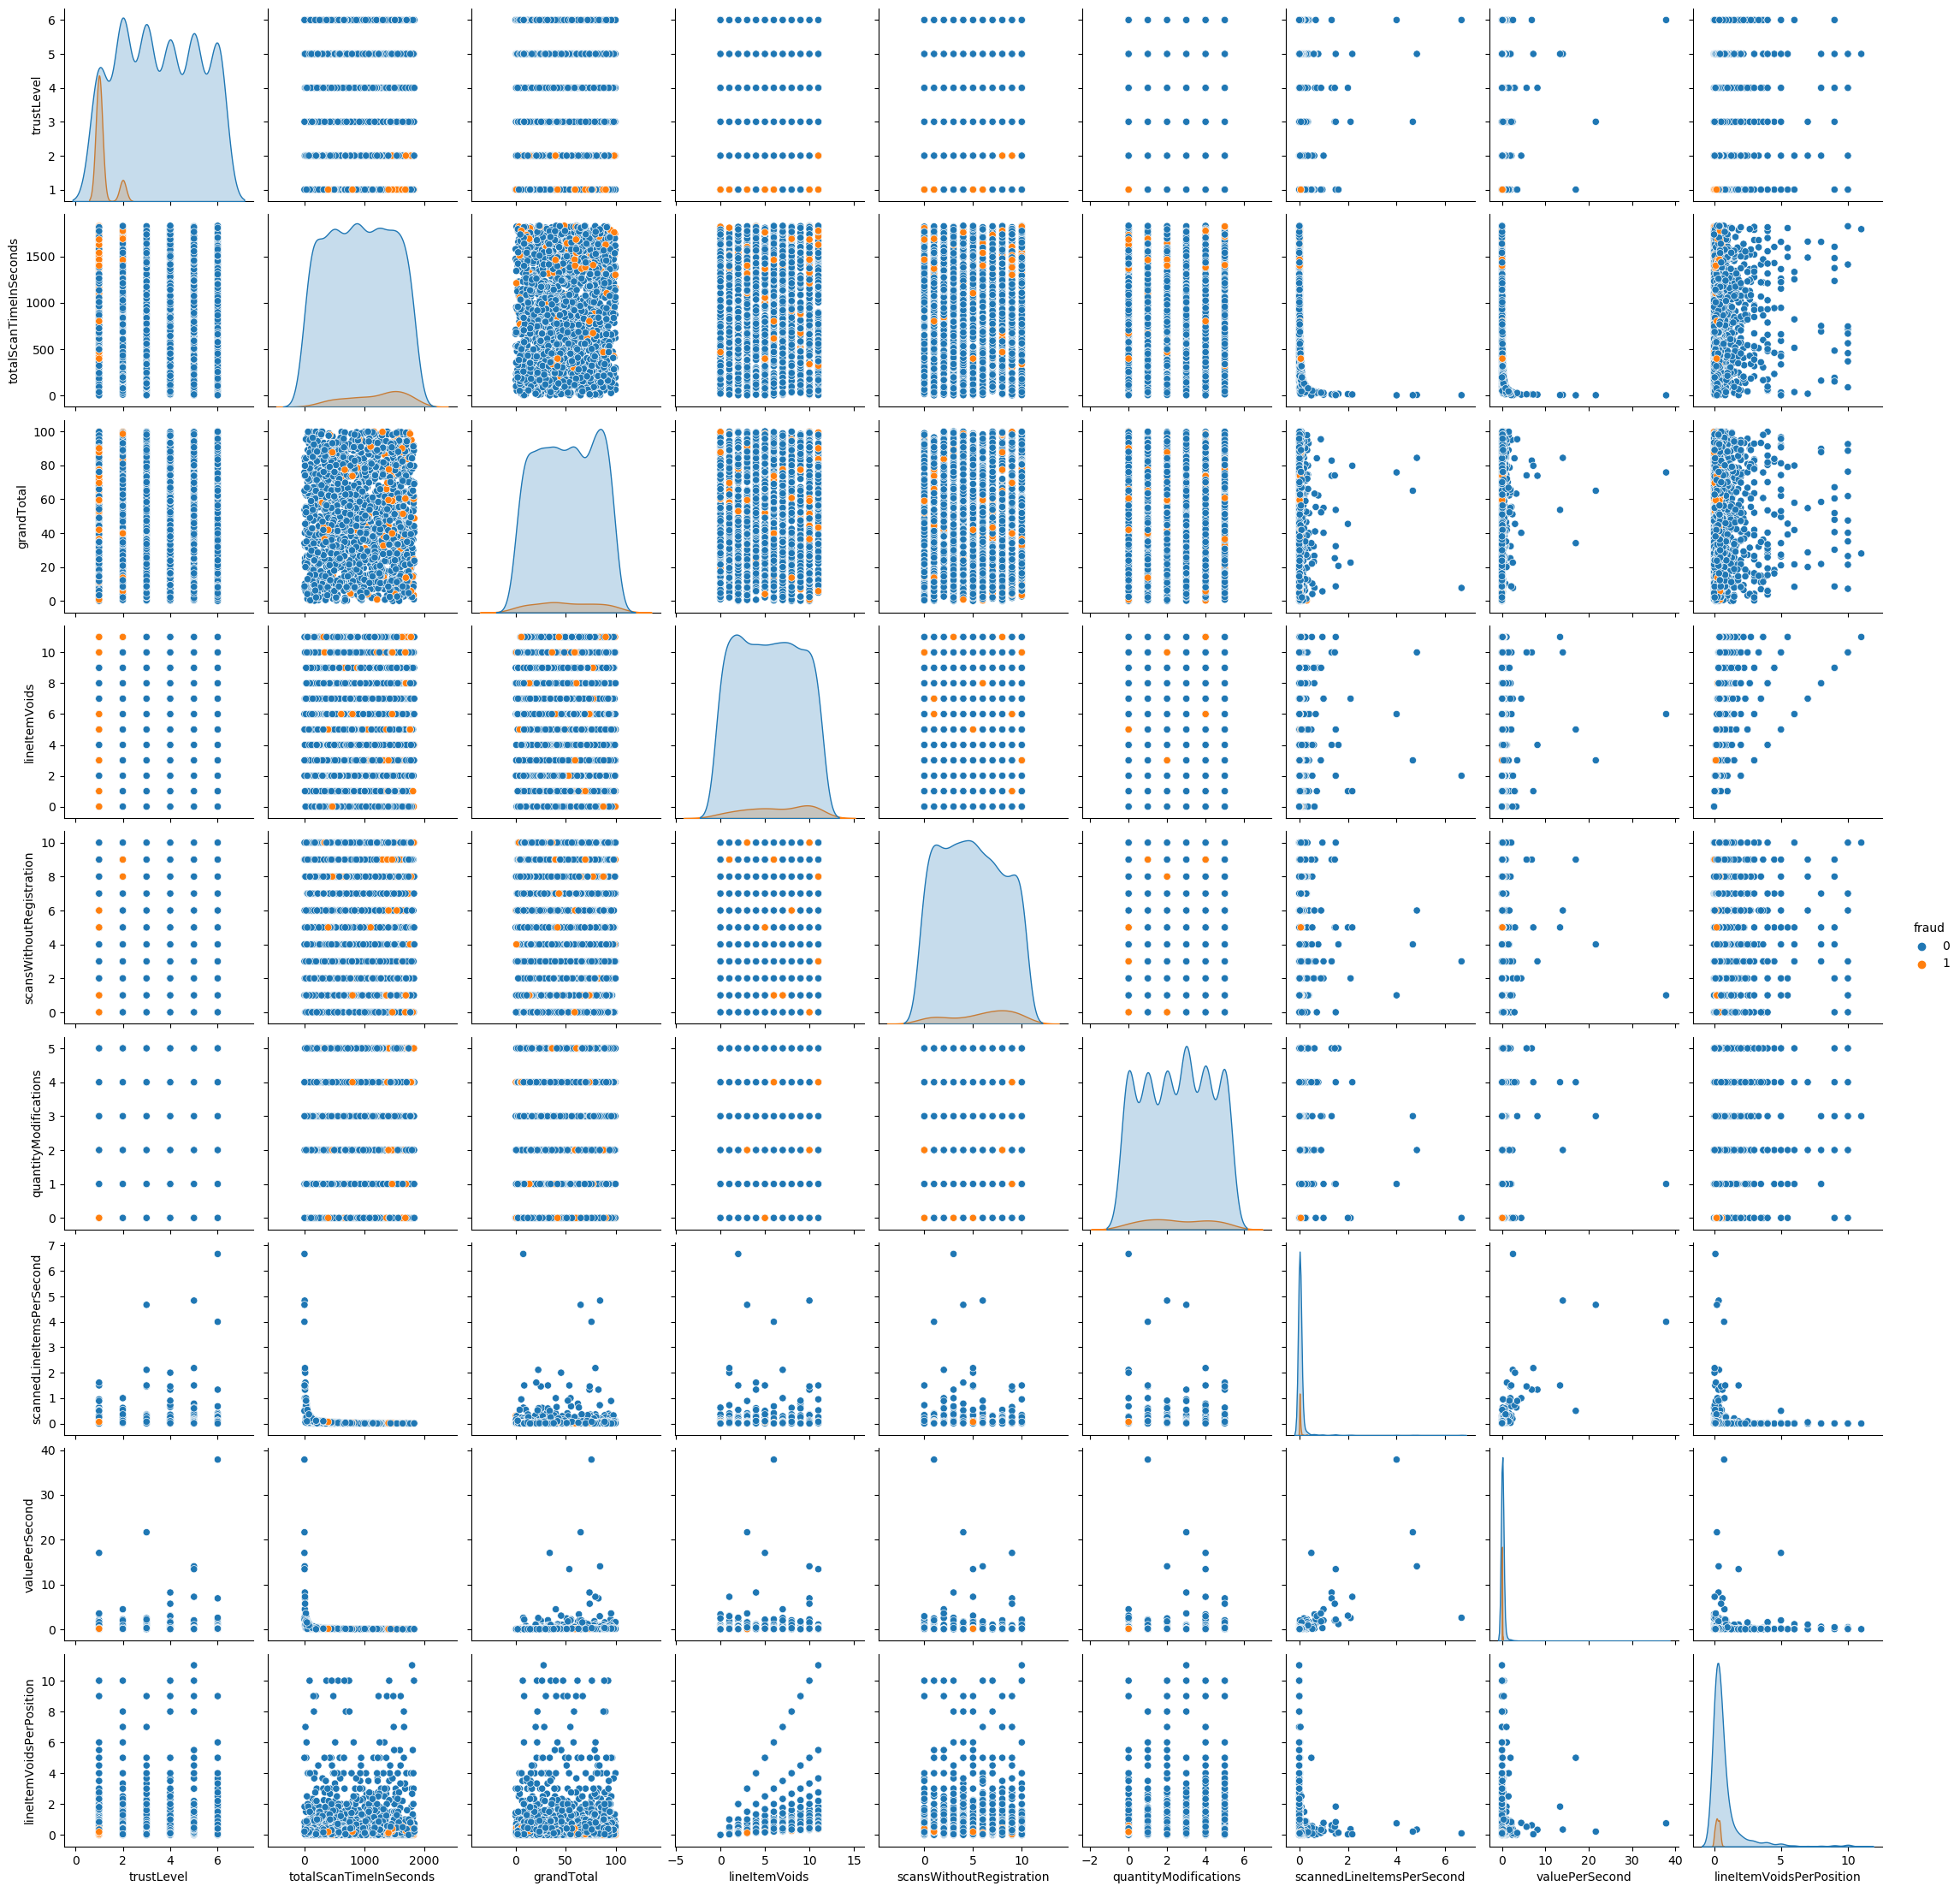

In [11]:
plt.figure(figsize=(15,10))

# use the seaborn pairplot function to create a scatter plot matrix
sns.pairplot(train, hue='fraud');

**Insights**:
* Creating scatter plots for each pair of input variables can be a useful way to visualize relationships between variables and identify patterns in the data.

# 3. Machine Learning (detecting patterns and building a fraud detection model)

**import important libraries**

In [12]:
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_val_score,
    StratifiedKFold,
    cross_val_predict,
    train_test_split,
    GridSearchCV,
    cross_validate,
    StratifiedKFold,
)
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    f1_score,
    roc_auc_score,
    recall_score,
    accuracy_score,
)
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

**Pre-process dataset**

In [13]:
def pre_process(data):
    
    # Create dependent and independent variables
    X = data.drop('fraud',axis=1)
    X = X.reset_index(drop=True)
    y = data['fraud']

    # Set trustlevel to 'object'
    X['trustLevel'] = X['trustLevel'].astype('object')
    
    # select only the numeric columns
    numeric_columns = X.select_dtypes(include='number').columns
    X_numeric = X[numeric_columns]
    
    # create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # fit the scaler to the numeric columns and transform the data
    scaled_X_numeric = scaler.fit_transform(X_numeric)
    
    # create a new data frame with the scaled numeric columns
    scaled_numeric_df = pd.DataFrame(scaled_X_numeric, columns=numeric_columns)
    
    # create dummy variables for the object columns
    X_dummies = pd.get_dummies(X['trustLevel'],drop_first=True,prefix='Trust_level')
    
    # concatenate the dummy variables with the scaled numeric data frame
    X = pd.concat([scaled_numeric_df, X_dummies], axis=1)
    
    return X,y


#get the independent and dependent variables
X,y = pre_process(train)

## PCA
PCA can help identify underlying patterns in the data that may not be immediately apparent when looking at the raw data.

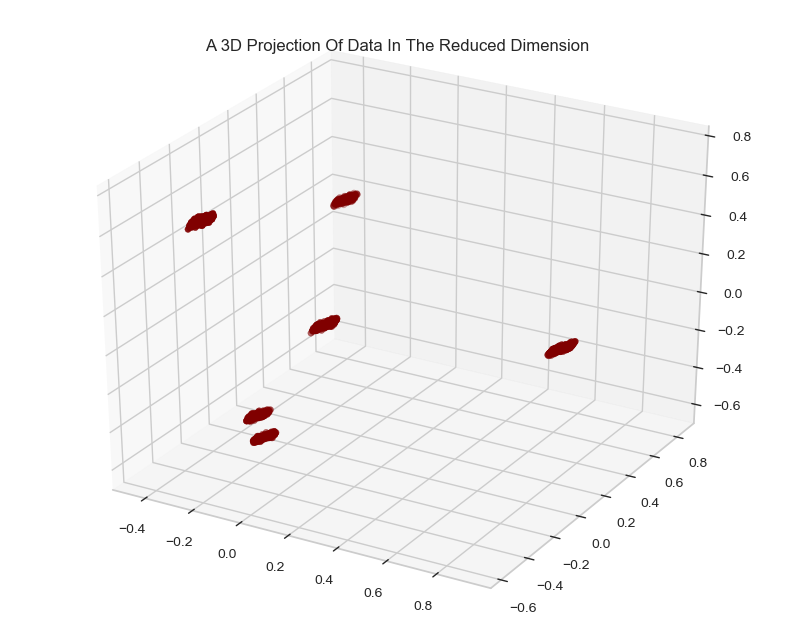

In [14]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(X), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

a =PCA_ds["col1"]
b =PCA_ds["col2"]
c =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(a,b,c, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

**Insights**:
* We can see that all the points are sparsely distributed and far away from each other (they are in different clusters), it may be appropriate to use a model that is able to capture non-linear relationships in the data.
* Potential Models: SVM, Random Forests, XG Boost.

## Clustering
Clustering is a technique that can be used to group similar items together. In the context of customer data, clustering can be used to identify patterns and find insights about the customers.

Elbow Method to determine the number of clusters to be formed:


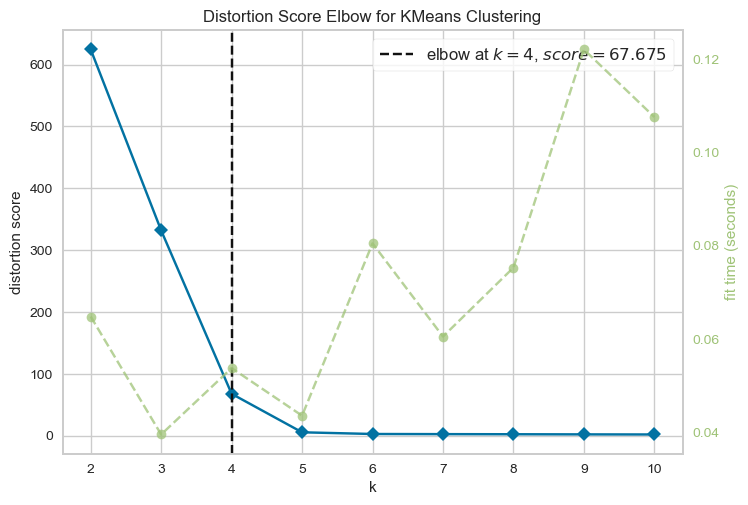

In [15]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [16]:
data = train.copy()

#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

In [17]:
PCA_ds

,col1,col2,col3,Clusters
0,-0.209362,-0.525983,0.707675,3
1,-0.352408,0.768131,0.217024,2
2,-0.398074,0.774743,0.174229,2
3,-0.201849,-0.221827,-0.566803,0
4,-0.230992,-0.542088,0.691265,3
...,...,...,...,...
1874,-0.043335,-0.024725,-0.026449,0
1875,-0.022341,-0.008160,-0.018280,0
1876,-0.176934,-0.234932,-0.427370,0
1877,0.858677,0.113165,0.061565,1


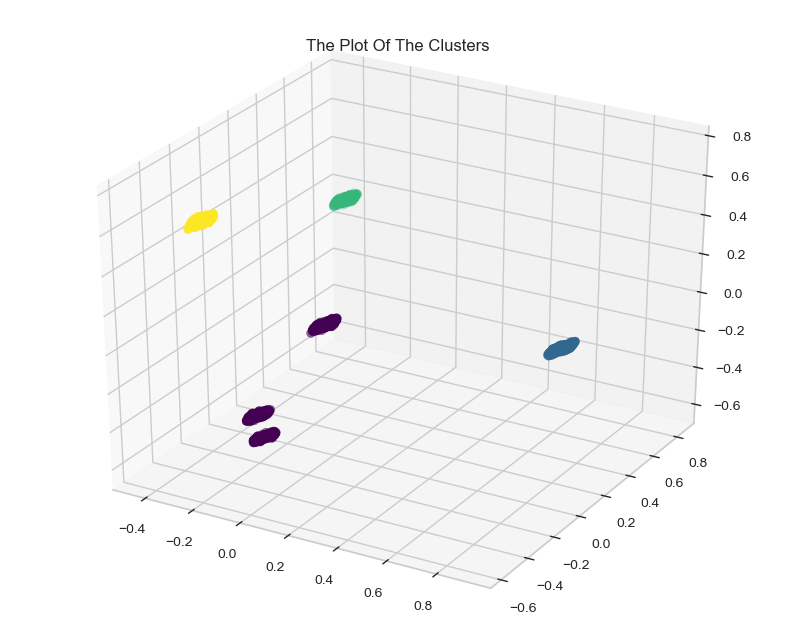

In [18]:
a =PCA_ds["col1"]
b =PCA_ds["col2"]
c =PCA_ds["col3"]

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(a, b, c, s=40, c=PCA_ds["Clusters"], marker='o',cmap='viridis')
ax.set_title("The Plot Of The Clusters")
plt.show()

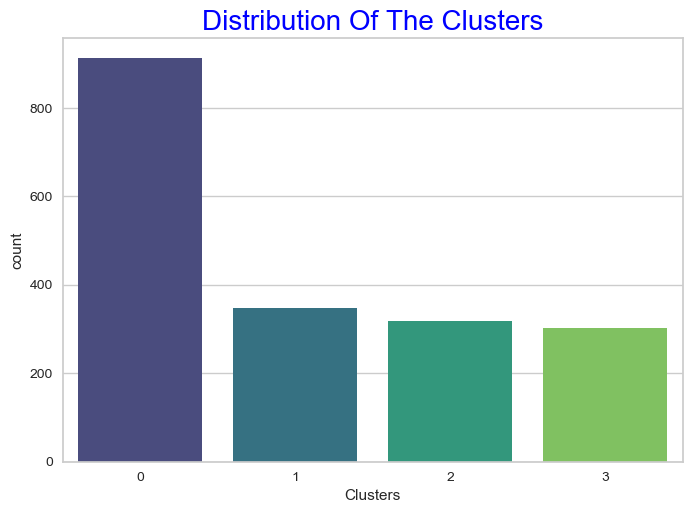

In [19]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters"], palette= 'viridis')
pl.set_title("Distribution Of The Clusters",size=20,color='blue')
plt.show()

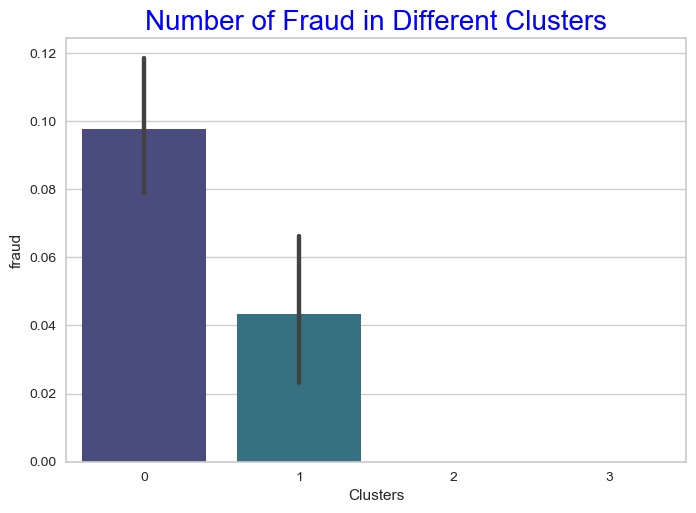

In [20]:
sns.barplot(y='fraud', x='Clusters', data=data, palette='viridis')
plt.title("Number of Fraud in Different Clusters",size=20,color='blue');


**Insights**:
* We can see that all fraud are committed in cluster 0 and 2.
* Let's find out their characteristics.

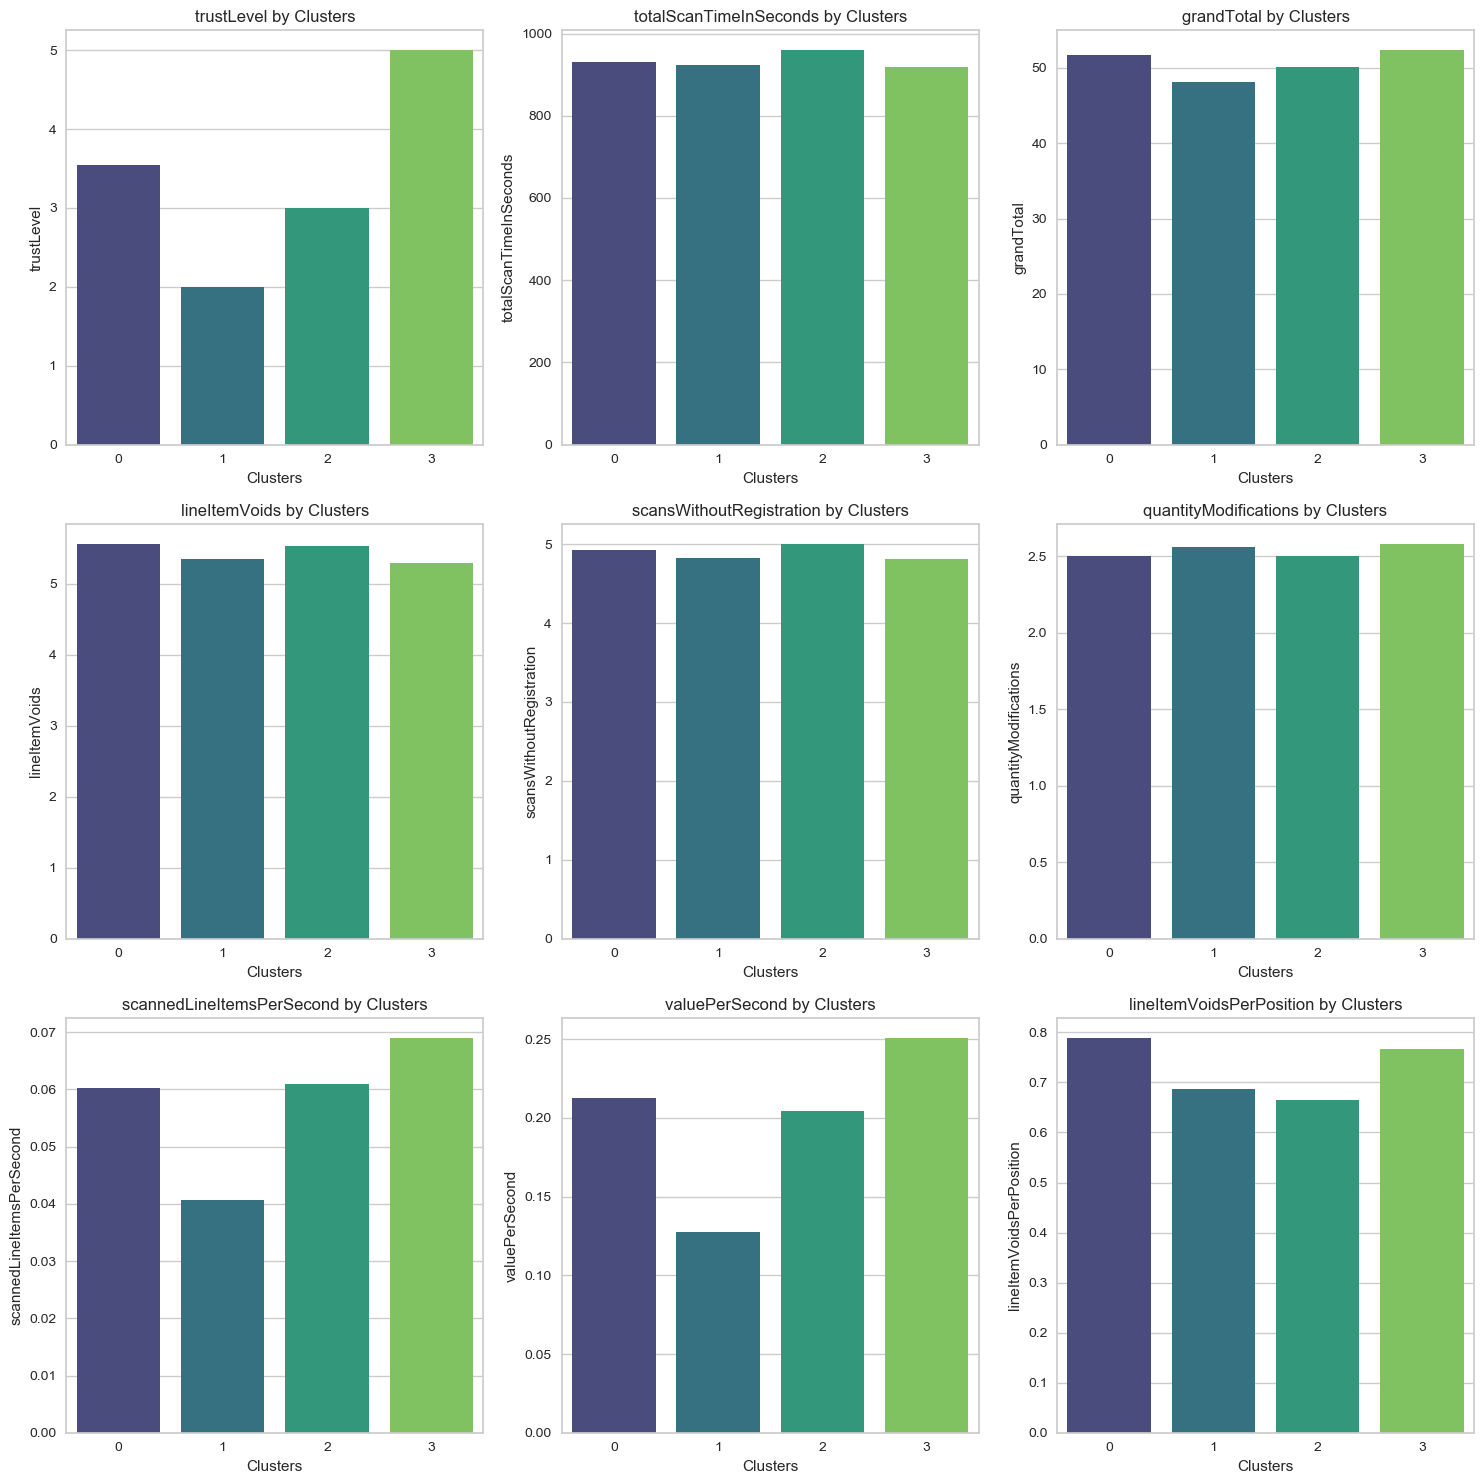

In [21]:
# Create a list of columns to plot
columns = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
           'scansWithoutRegistration', 'quantityModifications',
           'scannedLineItemsPerSecond', 'valuePerSecond',
           'lineItemVoidsPerPosition', 'fraud']

# Set the number of rows and columns for the subplots
nrows = 3
ncols = 3

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Flatten the axes object to a single list of axes
axs = axs.flatten()

# Iterate over the columns and plot each one
for ax, column in zip(axs, columns):
    sns.barplot(y=column, x='Clusters', data=data, palette='viridis', ax=ax,ci=None)
    ax.set_title(f"{column} by Clusters")

# Tighten the layout 
plt.tight_layout()


**Insights**:
* Trust Level: We can see that for Trust Level, cluster 0 and 2 (clusters that contain fraud) are relatively lower. This suggests that customers with a low Trust Level may be more likely to commit fraud. It may be worth further investigation to understand why this is the case.
* Scanned Line Items Per Second: For Scanned Line Items Per Second, clusters 0 and 2 (clusters that contain fraud) are also relatively lower than cluster 1 and 3. This may indicate that customers who commit fraud tend to scan fewer items per second. 
* Value per Second: For value per second, cluster 2 is the lowest. This could suggest that fraudsters in cluster 2 may be making smaller purchases, or may be purchasing items with a lower value.

## Imbalanced dataset

In [22]:
print('The dataset is extremely imbalanced')
print('-'*35)
print('Percentage of fraud:',round(train['fraud'].value_counts()[1] / train['fraud'].value_counts()[0] *100, 2), '%')

The dataset is extremely imbalanced
-----------------------------------
Percentage of fraud: 5.86 %


**Solutions:**
* We will use a combination of resampling and cost-sensitive methods to cope with imbalanced datasets, and will apply these techniques to the following models

**Models:**
* SVM
    * SVMs can perform well with non-linear data. They can effectively find the hyperplane that maximally separates the classes, even if the data is not linearly separable.
* Random Forests
    * Random forests are an ensemble learning method that can be used for classification and regression tasks. They are composed of multiple decision trees that are trained on different subsets of the data and combined to make predictions. Random forests are resistant to overfitting and can handle large amounts of noise in the data. This makes them a good choice for tasks where the data may be noisy or have missing values.
* XG Boost (eXtreme Gradient Boosting)
    * XGBoost is a gradient boosting algorithm that is generally faster than other boosting algorithms and can process data more efficiently. This makes it a good choice for tasks involving large amounts of data. It also allows users to specify a wide range of hyperparameters, which can be used to fine-tune the model's performance.


## Model Building

**Create a reference model**\
This is often used as a baseline model to compare the performance of other classifiers

In [23]:
dum_model = DummyClassifier(strategy='stratified',random_state=42) 

**Train models**

We will use `balanced-class-weight` and `SMOTETOMEK` to deal with imbalanced dataset

In [24]:
#param_grid for grid search

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

XGB_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'scale_pos_weight': [5, 10, 20]
}

SVM_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['auto', 'scale', 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced', {0:1, 1:5}, {0:1, 1:10}, {0:1, 1:20}]
}


model_param_grid = {
    'dummy': [dum_model, {}],
    'RF': [RandomForestClassifier(), RF_param_grid],
    'XGBoost': [XGBClassifier(), XGB_param_grid],
    'SVM': [SVC(probability=True), SVM_param_grid]
}


In [25]:
for name, [model, param_grid] in model_param_grid.items():
    print(name, model)

dummy DummyClassifier(random_state=42, strategy='stratified')
RF RandomForestClassifier()
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
SVM SVC(probability=True)


In [26]:
train_model = {}
for name, [model, param_grid] in model_param_grid.items():
    cv = StratifiedKFold(n_splits=5)
    grid = GridSearchCV(estimator=model, scoring='f1', cv=cv, param_grid=param_grid)
    # Fit the grid search object to the training data
    grid.fit(X, y)
    # Store the best estimator found by grid search in the dictionary
    train_model[name] = grid.best_estimator_

# Create the voting classifier using the base estimators
voting_clf = VotingClassifier(estimators=list(train_model.items()), voting='soft')
train_model['voting'] = voting_clf

In [27]:
train_copy = train_model.copy()

del train_copy['voting']

results = {}

for name, model in train_copy.items():
    
    cv = RepeatedStratifiedKFold(n_repeats=3,n_splits=10,random_state=42)
    score = cross_validate(estimator=model, X=X, y=y, scoring=['roc_auc', 'f1', 'precision', 'recall'], cv=cv)
    results[name] = {
    'roc_auc': score['test_roc_auc'],
    'f1': score['test_f1'],
    'precision': score['test_precision'],
    'recall': score['test_recall']
    }

#add voting to the results
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Create the stratified K-fold cross-validator
skf = RepeatedStratifiedKFold(n_repeats=3,n_splits=10,random_state=42)

# Initialize lists to store the scores
roc_auc_scores_bag = []
f1_scores_bag = []
precision_scores_bag = []
recall_scores_bag = []

# Loop through the folds
for train_index, test_index in skf.split(X, y):
    # Split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model on the train set
    train_model['voting'].fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = train_model['voting'].predict(X_test)
    roc_auc_scores_bag.append(roc_auc_score(y_test, y_pred))
    f1_scores_bag.append(f1_score(y_test, y_pred))
    precision_scores_bag.append(precision_score(y_test, y_pred))
    recall_scores_bag.append(recall_score(y_test, y_pred))

results['bagging'] = {
    'roc_auc': roc_auc_scores_bag,
    'f1': f1_scores_bag,
    'precision': precision_scores_bag,
    'recall': recall_scores_bag}
    


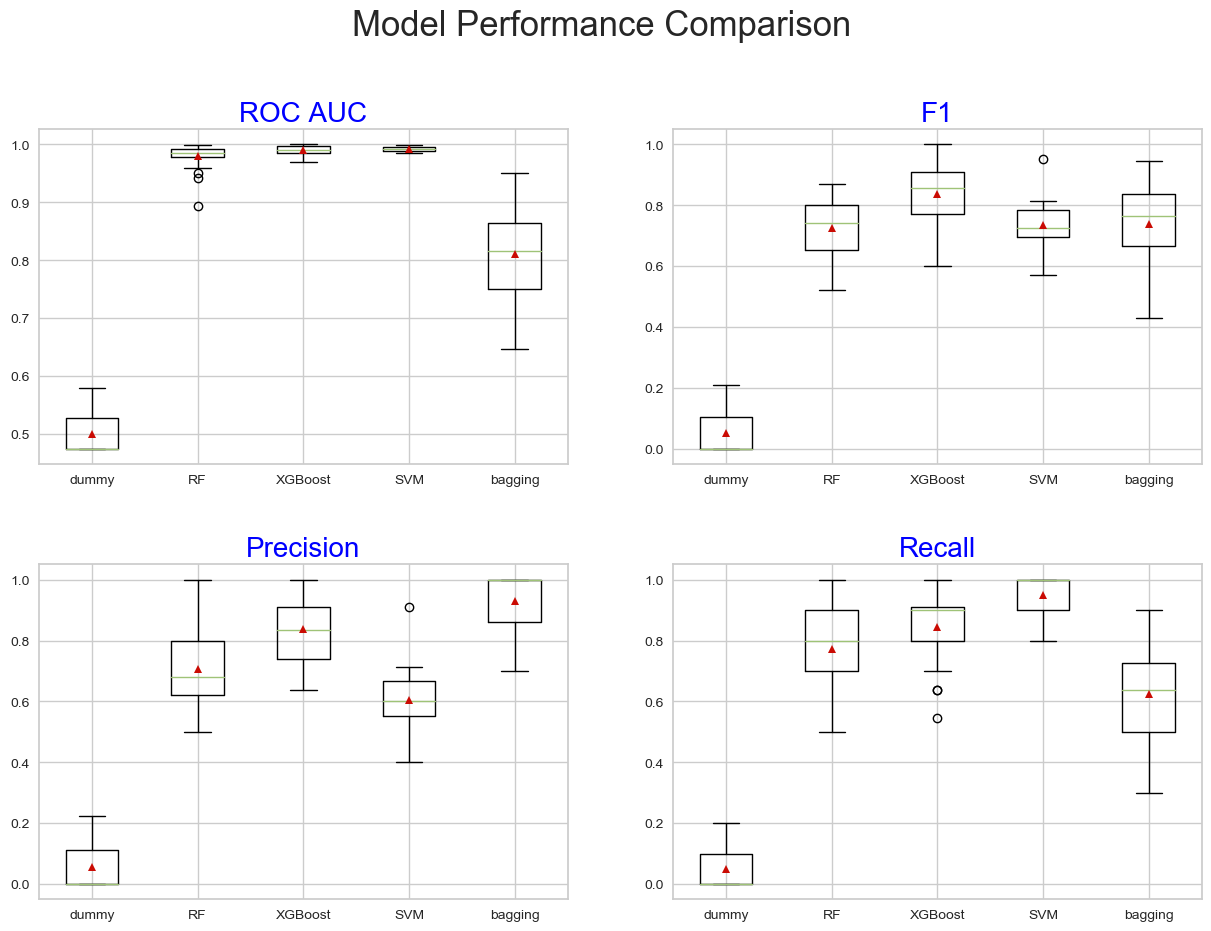

In [28]:
def plot_performance():

    # Extract the ROC AUC, F1, precision, and recall scores from the results
    roc_auc = [result['roc_auc'] for result in results.values()]
    f1 = [result['f1'] for result in results.values()]
    precision = [result['precision'] for result in results.values()]
    recall = [result['recall'] for result in results.values()]

    # Create a figure with 2 rows and 2 columns of subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.suptitle("Model Performance Comparison", fontsize=25, y=1)

    # Plot the boxplots for the ROC AUC metric
    axs[0, 0].boxplot(roc_auc, labels=results.keys(), showmeans=True)
    axs[0, 0].set_title("ROC AUC", size=20, color='blue')

    # Plot the boxplots for the F1 metric
    axs[0, 1].boxplot(f1, labels=results.keys(), showmeans=True)
    axs[0, 1].set_title("F1", size=20, color='blue')

    # Plot the boxplots for the precision metric
    axs[1, 0].boxplot(precision, labels=results.keys(), showmeans=True)
    axs[1, 0].set_title("Precision", size=20, color='blue')

    # Plot the boxplots for the recall metric
    axs[1, 1].boxplot(recall, labels=results.keys(), showmeans=True)
    axs[1, 1].set_title("Recall", size=20, color='blue')

plot_performance()

**Insights**:\
We can see that XG boost performs the best out of these four models in four different metrics. So, we will use XGBoost.

## 4. Predictions

In [29]:
#this is for the final validation
test = pd.read_csv('test.csv', sep='|')
result = pd.read_csv('realclass.csv') #real class

In [30]:
def pre_process(data):
    # Set trustlevel to 'object'
    data['trustLevel'] = data['trustLevel'].astype('object')
    
    # select only the numeric columns
    numeric_columns = data.select_dtypes(include='number').columns
    numeric_data = data[numeric_columns]
    
    # create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # fit the scaler to the numeric columns and transform the data
    scaled_numeric_data = scaler.fit_transform(numeric_data)
    
    # create a new data frame with the scaled numeric columns
    scaled_numeric_df = pd.DataFrame(scaled_numeric_data, columns=numeric_columns)
    
    # create dummy variables for the object columns
    dummy_data = pd.get_dummies(data['trustLevel'],drop_first=True,prefix='Trust_level')
    
    # concatenate the dummy variables with the scaled numeric data frame
    data = pd.concat([scaled_numeric_df, dummy_data], axis=1)
    
    return data

test = pre_process(test)

In [31]:
predictions = train_model['XGBoost'].predict(test)

`The optimal result is the one whose solution achieves the highest monetary profit.`

**Cost Sensitive Matrix**:

|               | actual 1 (fraud) | actual 0 (no fraud) |
|:------------:|:---------------:|:---------------:|
| **predicted 1 (fraud)** | 5 | -25 |
| **predicted 0 (no fraud)** | -5 | 0 |


That is: `The goal` is to maximize profit by minimizing cost. To do this, we need to calculate the profit for each combination of predicted and actual values, and choose the combination that maximizes profit.

**XG Model**

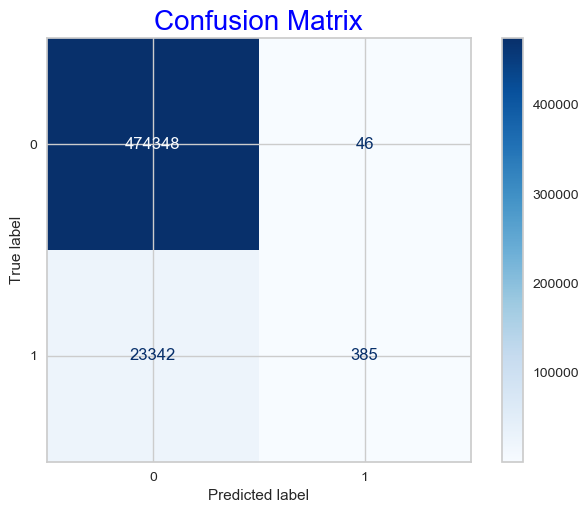

In [32]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_score, plot_roc_curve

confusion_mat = pd.DataFrame(confusion_matrix(result, predictions))
plot_confusion_matrix(train_model['XGBoost'], test, result, cmap=plt.cm.Blues)
plt.title('Confusion Matrix',size=20,color='blue');

**Insights**:
* We can see that xg boost classified a lot of classes into 0 to avoid the large penalty of false positive

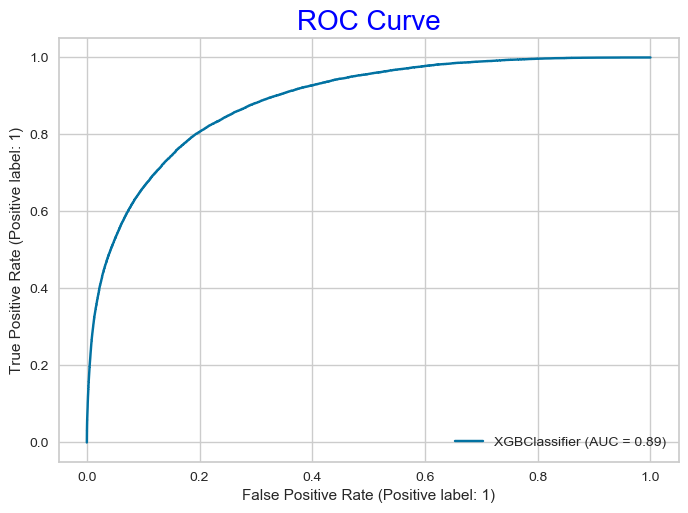

In [33]:
plot_roc_curve(train_model['XGBoost'], test, result)
plt.title('ROC Curve',size=20,color='blue');

In [34]:
confusion_mat
#The rows represent the predicted values and the columns represent the actual values

,0,1
0,474348,46
1,23342,385


In [35]:
cost_true_positive = 5
cost_false_positive = -25
cost_false_negative = -5
cost_true_negative = 0

true_positive = confusion_mat[1][1]
false_positive = confusion_mat[0][1]
false_negative = confusion_mat[1][0]
true_negative = confusion_mat[0][0]

total_cost_XG = (cost_true_positive * true_positive) + (cost_false_positive * false_positive) + (cost_false_negative * false_negative) + (cost_true_negative * true_negative)

print(total_cost_XG)


-581855


**Dummy Model**

In [36]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

predictions_dum = train_model['dummy'].predict(test)
confusion_mat_dum = pd.DataFrame(confusion_matrix(result, predictions_dum))

In [37]:
# Base line model (Dummt model)

true_positive_Dum = confusion_mat_dum[1][1]
false_positive_Dum = confusion_mat_dum[0][1]
false_negative_Dum = confusion_mat_dum[1][0]
true_negative_Dum = confusion_mat_dum[0][0]

total_cost_Dum = (cost_true_positive * true_positive_Dum) + (cost_false_positive * false_positive_Dum) + (cost_false_negative * false_negative_Dum) + (cost_true_negative * true_negative_Dum)


In [38]:
print(total_cost_Dum)

-684405


## Cost Saving

In [39]:
saved_costs = np.abs(total_cost_Dum - total_cost_XG)
print(f'The XG model helps save around {saved_costs}')

The XG model helps save around 102550


## Save the Model

In [40]:
import pickle

# save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(train_model['XGBoost'], file)

In [ ]:
## save the scaler

def pre_process(data):
    
    # Create dependent and independent variables
    X = data.drop('fraud',axis=1)
    X = X.reset_index(drop=True)
    y = data['fraud']

    # Set trustlevel to 'object'
    X['trustLevel'] = X['trustLevel'].astype('object')
    
    # select only the numeric columns
    numeric_columns = X.select_dtypes(include='number').columns
    X_numeric = X[numeric_columns]
    
    # create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # fit the scaler to the numeric columns and transform the data
    scaler.fit(X_numeric)
    
    return scaler

scaler = pre_process(train)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

### Thank you! Please let me know if you have any questions!